In [199]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import os,itertools, time
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_selection import RFECV, SequentialFeatureSelector

from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn import metrics


import numpy as np
from keras.layers import Dense, Dropout, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.models import Model
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.layers import SpatialDropout1D
from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

In [200]:
import tensorflow as tf
print("Tensorflow Verstion", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow Verstion 2.9.0
Num GPUs Available:  1


In [201]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17174413230297152722
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1084620800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15311896525364405850
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:00:10.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [202]:
# Reading clean cicids2017 csv file
df = pd.read_csv('data/FeatureSelection_binaryClass.csv')

In [60]:
df.head()

,Unnamed: 0,DestinationPort,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthMin,FlowBytes/s,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATMin,...,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveStd,ActiveMax,ActiveMin,IdleStd,IdleMin,Label
0,0,49188.0,6.0,0.000000,0.0,3.000000e+06,4.0,4.0,4.000,4.0,...,329.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0
1,1,49486.0,6.0,0.000000,0.0,4.000000e+06,3.0,3.0,3.000,3.0,...,245.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0
2,2,88.0,0.0,111.967895,0.0,1.474548e+06,2.0,609.0,101.500,2.0,...,8192.0,2053.0,5.0,20.0,0.0,0.0,0.0,0.0,0.0,0
3,3,88.0,0.0,136.153814,0.0,4.232082e+06,1.0,879.0,109.875,1.0,...,8192.0,2053.0,7.0,20.0,0.0,0.0,0.0,0.0,0.0,0
4,4,88.0,0.0,682.482560,0.0,5.329310e+06,1.0,1160.0,145.000,1.0,...,8192.0,2053.0,7.0,20.0,0.0,0.0,0.0,0.0,0.0,0


In [203]:
# drop columns Unnamed  0
df = df.drop(columns = 'Unnamed: 0')
df.head()

,DestinationPort,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthMin,FlowBytes/s,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATMin,BwdIATTotal,...,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveStd,ActiveMax,ActiveMin,IdleStd,IdleMin,Label
0,49188.0,6.0,0.000000,0.0,3.000000e+06,4.0,4.0,4.000,4.0,0.0,...,329.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0
1,49486.0,6.0,0.000000,0.0,4.000000e+06,3.0,3.0,3.000,3.0,0.0,...,245.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0
2,88.0,0.0,111.967895,0.0,1.474548e+06,2.0,609.0,101.500,2.0,467.0,...,8192.0,2053.0,5.0,20.0,0.0,0.0,0.0,0.0,0.0,0
3,88.0,0.0,136.153814,0.0,4.232082e+06,1.0,879.0,109.875,1.0,764.0,...,8192.0,2053.0,7.0,20.0,0.0,0.0,0.0,0.0,0.0,0
4,88.0,0.0,682.482560,0.0,5.329310e+06,1.0,1160.0,145.000,1.0,1022.0,...,8192.0,2053.0,7.0,20.0,0.0,0.0,0.0,0.0,0.0,0


# shuffle rows randomly

In [204]:
# considering only fifty percent of data
df=df.sample(frac=1).reset_index(drop=True)
df

,DestinationPort,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthMin,FlowBytes/s,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATMin,BwdIATTotal,...,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveStd,ActiveMax,ActiveMin,IdleStd,IdleMin,Label
0,80.0,6.0,0.000000,0.0,3.781208e+00,1.0,9520767.0,1.904153e+06,1.0,0.0,...,256.0,-1.0,5.0,20.0,0.0,2015.0,2015.0,0.0,9518752.0,1
1,443.0,0.0,149.152846,0.0,5.389508e+02,3.0,10100000.0,1.439697e+06,182.0,10100000.0,...,8192.0,62.0,7.0,20.0,0.0,81664.0,81664.0,0.0,9996212.0,0
2,26428.0,6.0,0.000000,6.0,9.436250e+00,3.0,0.0,0.000000e+00,0.0,3793929.0,...,229.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0
3,53.0,55.0,0.000000,134.0,8.645138e+02,218620.0,0.0,0.000000e+00,0.0,0.0,...,-1.0,-1.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0
4,53.0,33.0,0.000000,225.0,1.070286e+04,3.0,30826.0,1.027533e+04,3.0,4.0,...,-1.0,-1.0,3.0,20.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425722,80.0,0.0,10.263203,0.0,1.064669e+05,5.0,680.0,3.400000e+02,92.0,109233.0,...,8192.0,229.0,2.0,20.0,0.0,0.0,0.0,0.0,0.0,1
2425723,53.0,40.0,0.000000,179.0,1.684615e+06,1.0,1.0,1.000000e+00,1.0,2.0,...,-1.0,-1.0,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0
2425724,53.0,35.0,0.000000,76.0,6.970610e+03,1.0,1.0,1.000000e+00,1.0,1.0,...,-1.0,-1.0,1.0,40.0,0.0,0.0,0.0,0.0,0.0,0
2425725,52286.0,0.0,0.000000,0.0,0.000000e+00,89.0,0.0,0.000000e+00,0.0,0.0,...,362.0,32832.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0


In [205]:
df.tail(20)

,DestinationPort,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthMin,FlowBytes/s,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATMin,BwdIATTotal,...,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveStd,ActiveMax,ActiveMin,IdleStd,IdleMin,Label
2425707,51725.0,6.0,189.504617,0.0,9.330000e+07,3.0,3.0,3.000000e+00,3.0,0.0,...,60.0,-1.0,1.0,20.0,0.00000,0.0,0.0,0.000000e+00,0.0,0
2425708,80.0,0.0,145.529378,0.0,1.404620e+02,1.0,85100000.0,1.700000e+07,1.0,85200000.0,...,0.0,235.0,3.0,20.0,0.00000,10997.0,10997.0,0.000000e+00,85100000.0,1
2425709,80.0,0.0,10.263203,0.0,4.513587e+05,6.0,24052.0,1.202600e+04,6.0,25741.0,...,8192.0,229.0,2.0,20.0,0.00000,0.0,0.0,0.000000e+00,0.0,1
2425710,53.0,47.0,0.000000,103.0,1.744186e+06,3.0,4.0,4.000000e+00,4.0,3.0,...,-1.0,-1.0,1.0,20.0,0.00000,0.0,0.0,0.000000e+00,0.0,0
2425711,35462.0,0.0,0.000000,0.0,0.000000e+00,86.0,0.0,0.000000e+00,0.0,0.0,...,358.0,339.0,0.0,32.0,0.00000,0.0,0.0,0.000000e+00,0.0,0
2425712,53.0,44.0,0.000000,100.0,3.759791e+05,3.0,3.0,3.000000e+00,3.0,3.0,...,-1.0,-1.0,1.0,32.0,0.00000,0.0,0.0,0.000000e+00,0.0,0
2425713,40451.0,0.0,0.000000,0.0,0.000000e+00,26.0,19815.0,9.907500e+03,3650.0,0.0,...,33.0,261.0,0.0,32.0,0.00000,0.0,0.0,0.000000e+00,0.0,0
2425714,80.0,0.0,10.263203,0.0,6.536003e+03,12.0,811.0,4.055000e+02,113.0,1779715.0,...,8192.0,229.0,2.0,20.0,0.00000,0.0,0.0,0.000000e+00,0.0,1
2425715,443.0,0.0,46.132057,0.0,8.211982e+03,40.0,379202.0,7.584040e+04,48.0,288562.0,...,65535.0,222.0,1.0,32.0,0.00000,0.0,0.0,0.000000e+00,0.0,0
2425716,36588.0,6.0,0.000000,6.0,1.019376e+01,2.0,0.0,0.000000e+00,0.0,4119267.0,...,229.0,0.0,0.0,20.0,0.00000,0.0,0.0,0.000000e+00,0.0,0


# Train and Test Dataset

In [206]:
# put labels into y_train variable
Y = df["Label"]
# Drop 'label' column
X = df.drop(labels = ["Label"],axis = 1)

In [207]:
X.shape, Y.shape

((2425727, 40), (2425727,))

In [208]:
df['Label'].unique()

array([1, 0])

In [209]:
df["Label"].value_counts()

Label
0    2035505
1     390222
Name: count, dtype: int64

In [210]:
type(X)

pandas.core.frame.DataFrame

In [211]:
features = list(X.columns)
features

['DestinationPort',
 'FwdPacketLengthMin',
 'FwdPacketLengthStd',
 'BwdPacketLengthMin',
 'FlowBytes/s',
 'FlowIATMin',
 'FwdIATTotal',
 'FwdIATMean',
 'FwdIATMin',
 'BwdIATTotal',
 'BwdIATStd',
 'BwdIATMax',
 'BwdIATMin',
 'BwdHeaderLength',
 'FwdPackets/s',
 'BwdPackets/s',
 'MinPacketLength',
 'PacketLengthVariance',
 'FINFlagCount',
 'SYNFlagCount',
 'PSHFlagCount',
 'ACKFlagCount',
 'URGFlagCount',
 'CWEFlagCount',
 'ECEFlagCount',
 'Down/UpRatio',
 'AvgFwdSegmentSize',
 'AvgBwdSegmentSize',
 'FwdHeaderLength.1',
 'SubflowFwdBytes',
 'SubflowBwdBytes',
 'Init_Win_bytes_forward',
 'Init_Win_bytes_backward',
 'act_data_pkt_fwd',
 'min_seg_size_forward',
 'ActiveStd',
 'ActiveMax',
 'ActiveMin',
 'IdleStd',
 'IdleMin']

In [212]:
#Scalling numerical attributes

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Turn back to dataframe
X = pd.DataFrame(X_scaled, columns=features)
X

,DestinationPort,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthMin,FlowBytes/s,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATMin,BwdIATTotal,...,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveStd,ActiveMax,ActiveMin,IdleStd,IdleMin
0,-0.456851,-0.214180,-0.265803,-0.606120,-0.052417,-0.056358,-0.206178,-0.110216,-0.127274,-0.375661,...,-0.007711,-0.479931,-0.254915,-0.001778,0.002751,-0.113061,-0.159791,-0.105982,-0.118364,0.011137
1,-0.437990,-0.311710,0.227685,-0.606120,-0.052397,-0.056358,-0.189951,-0.155876,-0.127255,-0.047036,...,-0.005783,0.061659,-0.247982,0.001131,0.002751,-0.113061,-0.087782,0.021890,-0.118364,0.030240
2,0.912118,-0.214180,-0.265803,-0.522001,-0.052417,-0.056358,-0.472898,-0.297408,-0.127274,-0.252217,...,-0.007699,-0.481774,-0.254805,-0.009051,0.002751,-0.113061,-0.161613,-0.109217,-0.118364,-0.369714
3,-0.458254,0.582316,-0.265803,1.272538,-0.052385,0.016667,-0.472898,-0.297408,-0.127274,-0.375661,...,-0.007657,-0.497470,-0.254915,-0.009051,0.002751,-0.113061,-0.161613,-0.109217,-0.118364,-0.369714
4,-0.458254,0.224706,-0.265803,2.548343,-0.052020,-0.056358,-0.472035,-0.296398,-0.127274,-0.375661,...,-0.007527,-0.497470,-0.254915,-0.004687,0.002751,-0.113061,-0.161613,-0.109217,-0.118364,-0.369714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425722,-0.456851,-0.311710,-0.231846,-0.606120,-0.048469,-0.056357,-0.472879,-0.297374,-0.127264,-0.372107,...,-0.002964,0.061659,-0.229602,-0.006142,0.002751,-0.113061,-0.161613,-0.109217,-0.118364,-0.369714
2425723,-0.458254,0.338491,-0.265803,1.903431,0.010061,-0.056358,-0.472898,-0.297408,-0.127274,-0.375661,...,-0.007565,-0.497470,-0.254915,-0.007596,0.002761,-0.113061,-0.161613,-0.109217,-0.118364,-0.369714
2425724,-0.458254,0.257216,-0.265803,0.459387,-0.052159,-0.056358,-0.472898,-0.297408,-0.127274,-0.375661,...,-0.007649,-0.497470,-0.254915,-0.007596,0.002768,-0.113061,-0.161613,-0.109217,-0.118364,-0.369714
2425725,2.255628,-0.311710,-0.265803,-0.606120,-0.052417,-0.056329,-0.472898,-0.297408,-0.127274,-0.375661,...,-0.007711,-0.472697,3.358570,-0.009051,0.002761,-0.113061,-0.161613,-0.109217,-0.118364,-0.369714


In [213]:
X["Label"] = Y

In [214]:
X.shape

(2425727, 41)

In [215]:
X.head()

,DestinationPort,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthMin,FlowBytes/s,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATMin,BwdIATTotal,...,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveStd,ActiveMax,ActiveMin,IdleStd,IdleMin,Label
0,-0.456851,-0.214180,-0.265803,-0.606120,-0.052417,-0.056358,-0.206178,-0.110216,-0.127274,-0.375661,...,-0.479931,-0.254915,-0.001778,0.002751,-0.113061,-0.159791,-0.105982,-0.118364,0.011137,1
1,-0.437990,-0.311710,0.227685,-0.606120,-0.052397,-0.056358,-0.189951,-0.155876,-0.127255,-0.047036,...,0.061659,-0.247982,0.001131,0.002751,-0.113061,-0.087782,0.021890,-0.118364,0.030240,0
2,0.912118,-0.214180,-0.265803,-0.522001,-0.052417,-0.056358,-0.472898,-0.297408,-0.127274,-0.252217,...,-0.481774,-0.254805,-0.009051,0.002751,-0.113061,-0.161613,-0.109217,-0.118364,-0.369714,0
3,-0.458254,0.582316,-0.265803,1.272538,-0.052385,0.016667,-0.472898,-0.297408,-0.127274,-0.375661,...,-0.497470,-0.254915,-0.009051,0.002751,-0.113061,-0.161613,-0.109217,-0.118364,-0.369714,0
4,-0.458254,0.224706,-0.265803,2.548343,-0.052020,-0.056358,-0.472035,-0.296398,-0.127274,-0.375661,...,-0.497470,-0.254915,-0.004687,0.002751,-0.113061,-0.161613,-0.109217,-0.118364,-0.369714,0


In [216]:
X.shape[0]*0.8

1940581.6

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=47)


In [218]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1940581, 41), (1940581,), (485146, 41), (485146,))

In [219]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=47)

In [220]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1552464, 41), (1552464,), (388117, 41), (388117,))

In [221]:
# X_train = X[: int(X.shape[0]*0.8)]
# X_test = X[int(X.shape[0]*0.8):]

In [222]:
type(X_train), type(X_test)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [223]:
# Train and test dataset creation
y_train = X_train["Label"]
# Drop 'label' column
X_train = X_train.drop(labels = ["Label"],axis = 1)

y_test = X_test["Label"]
X_test = X_test.drop(labels=["Label"], axis = 1)

y_val = X_val["Label"]
X_val = X_val.drop(labels=["Label"], axis = 1)


In [224]:
type(X_train), type(X_test), type(X_val), type(y_train), type(y_test), type(y_val)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series)

# To categorical data

In [225]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [226]:
y_train.shape, y_test.shape, y_val.shape

((1552464, 2), (485146, 2), (388117, 2))

In [227]:
# changing dataframe into numpy array
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_val = X_val.to_numpy()

In [228]:
X_train.shape, X_test.shape, X_val.shape

((1552464, 40), (485146, 40), (388117, 40))

# Re shaping train and test dataset for CNN

In [229]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((1552464, 40),
 (1552464, 2),
 (485146, 40),
 (485146, 2),
 (388117, 40),
 (388117, 2))

In [230]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)


X_train.shape, X_test.shape, X_val.shape

((1552464, 40, 1), (485146, 40, 1), (388117, 40, 1))

In [231]:
len(X_train)

1552464

In [232]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1552464, 40, 1), (1552464, 2), (388117, 40, 1), (388117, 2))

# Building a first simple CNN Model

In [233]:
def model1():
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size = 3, activation='relu', input_shape=(40, 1)))
  model.add(MaxPooling1D(pool_size=(2)))
  model.add(Dropout(0.25))

  model.add(Conv1D(filters=64, kernel_size = 3, activation='relu'))
  model.add(MaxPooling1D(pool_size=(2)))

  model.add(Conv1D(filters=128, kernel_size = 3, activation='relu'))
  model.add(MaxPooling1D(pool_size=(2)))
  model.add(Dropout(0.25))  

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(2, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model


model = model1()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 38, 32)            128       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 19, 32)           0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 19, 32)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 17, 64)            6208      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 8, 64)            0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 6, 128)           

In [236]:
# model parameters
epochs = 50
batch_size = 128
num_classes = len(X['Label'].unique())
num_classes

2

# Trainig the model


In [238]:
# checkpoint_filepath = 'log/checkpoint-{epoch:02d}-{val_loss:.3f}.hdf5'
my_callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, min_delta=0.001, mode='max'),
#      the learning rate will be reduced by a factor of 0.1 if the validation loss does not improve after 5 epochs.
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

#     tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath),

]
history1 = model.fit(X_train,
                     y_train,
                     epochs = epochs,
                     batch_size = batch_size,
                     validation_data = (X_val, y_val),
                     
                     callbacks=[my_callbacks]
                     )

#saving model
model.save('cnn_binaryClassification.h5')

Epoch 1/50
12129/12129 [==============================] - 133s 11ms/step - loss: 0.0564 - accuracy: 0.9771 - val_loss: 0.0393 - val_accuracy: 0.9834 - lr: 0.0010
Epoch 2/50
12129/12129 [==============================] - 137s 11ms/step - loss: 0.0398 - accuracy: 0.9836 - val_loss: 0.0331 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 3/50
12129/12129 [==============================] - 134s 11ms/step - loss: 0.0367 - accuracy: 0.9846 - val_loss: 0.0323 - val_accuracy: 0.9859 - lr: 0.0010
Epoch 4/50
12129/12129 [==============================] - 131s 11ms/step - loss: 0.0351 - accuracy: 0.9853 - val_loss: 0.0297 - val_accuracy: 0.9868 - lr: 0.0010
Epoch 5/50
12129/12129 [==============================] - 131s 11ms/step - loss: 0.0332 - accuracy: 0.9860 - val_loss: 0.0290 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 6/50
12129/12129 [==============================] - 141s 12ms/step - loss: 0.0324 - accuracy: 0.9863 - val_loss: 0.0274 - val_accuracy: 0.9876 - lr: 0.0010
Epoch 7/50
12129/12129 [====

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12129/12129 [==============================] - 143s 12ms/step - loss: 0.0289 - accuracy: 0.9879 - val_loss: 0.0242 - val_accuracy: 0.9897 - lr: 0.0010
Epoch 14/50
12129/12129 [==============================] - 139s 11ms/step - loss: 0.0289 - accuracy: 0.9879 - val_loss: 0.0244 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 15/50
12129/12129 [==============================] - 132s 11ms/step - loss: 0.0284 - accuracy: 0.9881 - val_loss: 0.0269 - val_accuracy: 0.9882 - lr: 0.0010
Epoch 16/50
12129/12129 [==============================] - 134s 11ms/step - loss: 0.0282 - accuracy: 0.9882 - val_loss: 0.0240 - val_accuracy: 0.9899 - lr: 0.0010
Epoch 17/50
12126/12129 [============================>.] - ETA: 0s - loss: 0.0282 - accuracy: 0.9881
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
12129/12129 [==============================] - 130s 11ms/step - loss: 0.0282 - accuracy: 0.9881 - val_loss: 0.0275 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 18/50
12129/12129 [=====

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12129/12129 [==============================] - 129s 11ms/step - loss: 0.0219 - accuracy: 0.9909 - val_loss: 0.0202 - val_accuracy: 0.9915 - lr: 1.0000e-07
Epoch 43/50
12129/12129 [==============================] - 130s 11ms/step - loss: 0.0215 - accuracy: 0.9910 - val_loss: 0.0202 - val_accuracy: 0.9915 - lr: 1.0000e-07
Epoch 44/50
 3516/12129 [=======>......................] - ETA: 1:22 - loss: 0.0224 - accuracy: 0.9910

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12125/12129 [============================>.] - ETA: 0s - loss: 0.0217 - accuracy: 0.9909
Epoch 46: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
12129/12129 [==============================] - 138s 11ms/step - loss: 0.0217 - accuracy: 0.9909 - val_loss: 0.0202 - val_accuracy: 0.9915 - lr: 1.0000e-07
Epoch 47/50
12129/12129 [==============================] - 140s 12ms/step - loss: 0.0217 - accuracy: 0.9910 - val_loss: 0.0202 - val_accuracy: 0.9915 - lr: 1.0000e-08
Epoch 48/50
 2025/12129 [====>.........................] - ETA: 1:49 - loss: 0.0214 - accuracy: 0.9911

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12129/12129 [==============================] - 134s 11ms/step - loss: 0.0216 - accuracy: 0.9910 - val_loss: 0.0202 - val_accuracy: 0.9915 - lr: 1.0000e-08
Epoch 49/50
12129/12129 [==============================] - 131s 11ms/step - loss: 0.0218 - accuracy: 0.9910 - val_loss: 0.0202 - val_accuracy: 0.9915 - lr: 1.0000e-08
Epoch 50/50
12129/12129 [==============================] - 128s 11ms/step - loss: 0.0216 - accuracy: 0.9910 - val_loss: 0.0202 - val_accuracy: 0.9915 - lr: 1.0000e-08


In [239]:
 #check history of model
history = history1.history
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [240]:
len(history1.history['loss'])

50

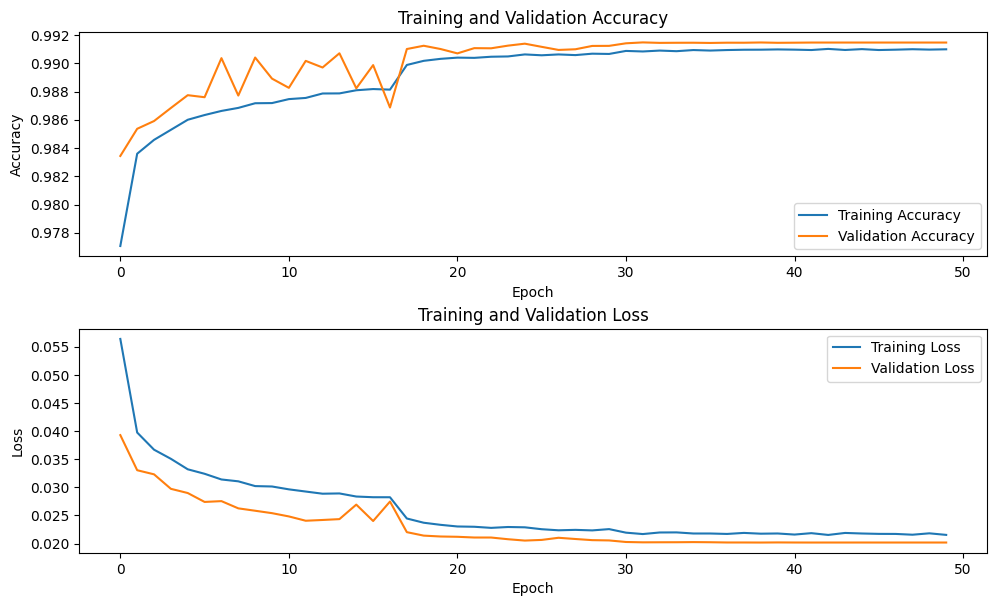

In [241]:
def plot_train_valdiation_loss_accuracy_grapy(history):
    epochs = len(history.history['loss'])
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(10, 6), dpi=100)
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.tight_layout(pad=0.5)
    
#     plt.savefig("cnn_Binaryclassification_train_valiadation_graph.png")
    plt.show()
    
# call function
plot_train_valdiation_loss_accuracy_grapy(history1)

# Confusion Matrix

In [242]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')   


15161/15161 [==============================] - 50s 3ms/step


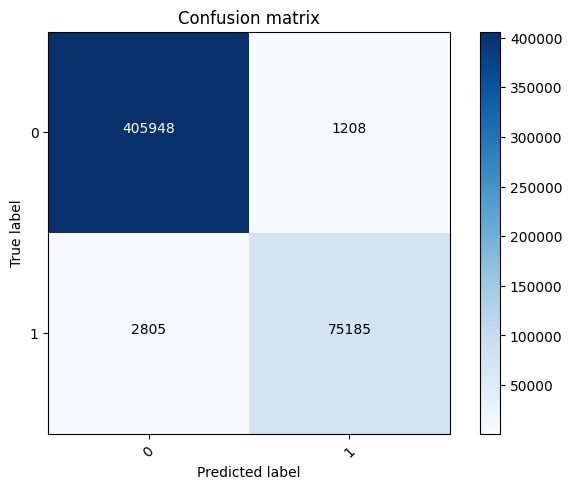

In [243]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(num_classes))

# Incorrect Predictions

Text(0, 0.5, 'Fraction classified incorrectly')

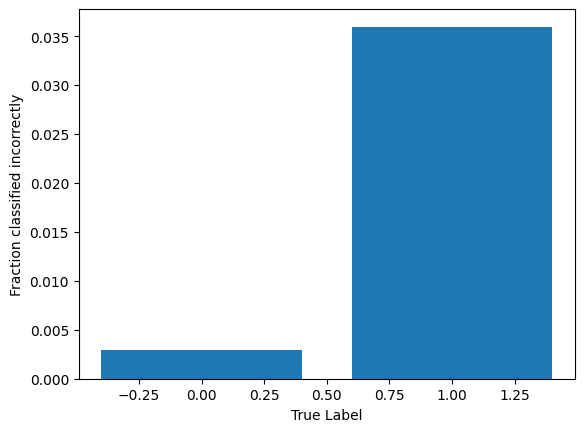

In [244]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(2),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [245]:
def prediction_inaccurate(confusion_mtx):
    #plotting inaccurately predicted
    label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
    plt.bar(np.arange(num_classes),label_frac_error)
    plt.xlabel('True Label')
    plt.ylabel('Fraction classified incorrectly')
    
def performance_measures(confusion_mtx):
    TP = confusion_mtx[0][0]
    FP = confusion_mtx[0][1]
    FN = confusion_mtx[1][0]
    TN = confusion_mtx[1][1]
    
    print("TP: ", TP)
    print("FP: ", FP)
    print("FN: ", FN)
    print("TN: ", TN)
    print("\n\n")
    
    Accuracy  = (TP+TN)/(TP+TN+FP+FN)
    Precision = TP/(TP + FP)
    Recall = TP/(TP+FN)
    F1_Score = 2 * (Precision * Recall)/(Precision + Recall)
    
    print("Accuracy: ", Accuracy)
    print("Precision: ", Precision)
    print("Recall: ", Recall)
    print("F1_Score: ", F1_Score)   

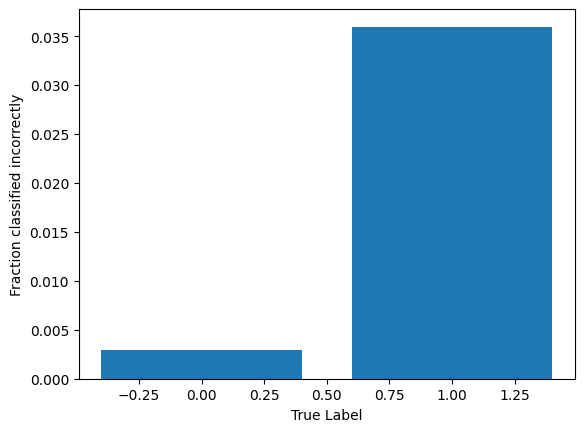

In [246]:
prediction_inaccurate(confusion_mtx)

In [247]:
performance_measures(confusion_mtx)

TP:  405948
FP:  1208
FN:  2805
TN:  75185



Accuracy:  0.9917282632444666
Precision:  0.9970330782304572
Recall:  0.9931376650446602
F1_Score:  0.9950815593405637
